In [1]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastpip import pip
from scipy.signal import savgol_filter    
import scipy
from scipy.optimize import curve_fit

# Preliminar analysis

In this script, I will try to put everything togheder to compute the transition among state ABAB to AAAA obtained by changing the magnetic interaction among particles from purely repulsive to purely attractive. How the magnetic field change in each experiment is explained and computed in script Setting_MagneticField.ipynb. 

In this preliminar analysis I will analyze Experiment 0. This experiment correspond with a purelly attractive interaction. 

To do:

    1. Choose interaction cut off, to separate "train" of particles. 
        Solved: Instead of trains of particles I will analyze pairs of particles.
    2. Develop algorith to define magnetization.
    3. Choose criterium for "density" in trains, the particle-particle distances are not constant.
        Solved: I will choose the mean distance among particles. 
    

## 1. 
The interaction cut off will be obtained from the magnetic susceptibility calculation. At 21 mT the particles reach a maximum distance of approx 70 $\mu m$. The size of the particles is 18.82 $\mu m$.

  <span style="color:red">To do: Take an image of scale bar with 10x Objective!</span>

## 2. 
To do that I need to have the tracking trajectories

    Solved: Trajectories obtained in Script Automatic_Tracking

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments"

filenames = [file for file in glob.glob(
    os.path.join(directory,('*_tracking.dat')))]
filenames

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP6_2023_03_23_16_41_46_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP9_2023_03_23_16_16_55_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP8_2023_03_23_16_23_59_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP9_2023_03_23_16_13_44_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP7_2023_03_23_16_31_57_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP9_2023_03_23_16_12_21_tracking.dat',
 '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/wi

In [3]:
# for file_no, filename in enumerate(filenames[0:]):

#     trj = pd.read_csv(filename[:filename.find("_tracking.dat")]+"_tracking.dat", index_col = [0,1], sep ="\t")

In [4]:
name = 'EXP7_2023_03_23_16_34_05'

In [5]:
trj = pd.read_csv(os.path.join(directory,(name+'_tracking.dat')),sep = '\t', usecols = ['frame','particle','x','y'])

In [6]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(28,
 array([  1,   2,   3,   6,   7,   8,  10,  12,  26,  27,  35,  36,  38,
         39,  40,  41,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53, 112]))

# Checking tracking

In [7]:
#trj = trj.query('frame < 1000')

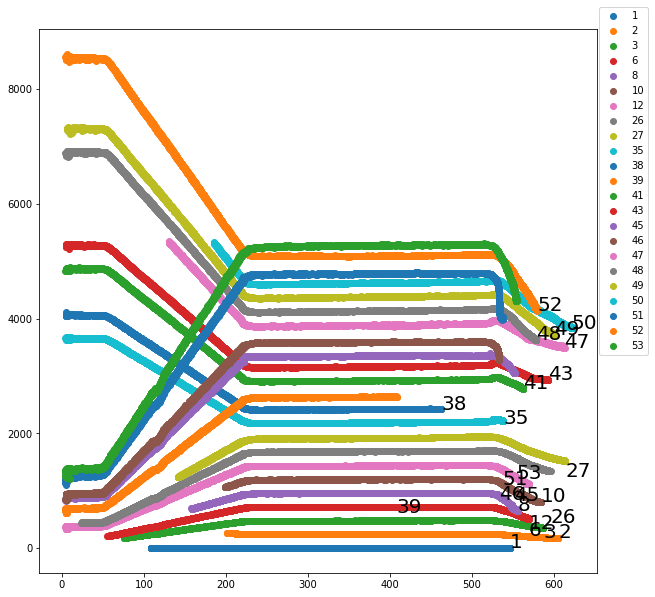

In [31]:
fig, ax = plt.subplots(1, figsize = (10,10))
i = 0
for p, gr in trj.groupby('particle'):
    
    plt.plot(gr.x, gr.y*i, 'o', label = p)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.text(gr.x.max(), gr.y.min()*i, s = str(p), size = 20)
    
    i = i+1

### To remove particles that did not cross the bifurcation

In [30]:
trj = trj[trj.particle != 40] # To drop unuseful particles

# Functions used during analysis

In [14]:
def y_bifurcation_position(df):
    """In this function I will locate the bifurcation position"""
    
    y, x , _ = plt.hist(df['y'], bins = 40, )
    y_bif = x[np.argmax(y)]
    
    return y_bif, df

def x_bifurcation_position(df, y_bif):
    """In this function I will find the x value of the bifurcation"""
    
    particles = df.particle.unique()
    points = []
    for i in particles:
        
        particle = trj.query('particle =='+str(i))

        data = np.stack((particle.x, particle.y), axis=-1)
        points.append(pip(data,4))
    
    points_ar = np.array(points)
    new_df = points_ar.reshape((len(points_ar[0])*len(points_ar),2))
    df = pd.DataFrame(data=new_df, columns = ['x', 'y'])
    y_bifurcation_plus = y_bif+10
    y_bifurcation_minus = y_bif-10

    df_filtered = df.query('y < '+str(y_bifurcation_plus)+' & y > '+str(y_bifurcation_minus))
    x_bif = df_filtered.x.min()
    return x_bif

In [15]:
def improve_x_and_y_bif(trj, x_bif, y_bif):
    
    """This function will improve the first estimation of x_bif and y_bif
        and will return a fit of the channel"""
    x_int = []
    y_int = []
    fit=[]
    
    for i in range(0,len(trj['particle'].unique())):
        
        particle = trj['particle'].unique()[i] # Select a particle trj
        
        print(particle)

        x1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).x
        y1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).y

        x2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).x
        y2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).y
            
        fit1 = np.poly1d(np.polyfit(x1, y1, 1)) # fit biburcation
        fit2 = np.poly1d(np.polyfit(x2, y2, 1)) # fit channel

        fit.append(np.poly1d(np.polyfit(x2, y2, 1))) # fit channel
        # compute intersection among fits
        x_int.append((fit2[0]-fit1[0])/(fit1[1]-fit2[1]))
        y_int.append(fit1[1]*x_int[i]+fit1[0])
        
    x_int = np.mean(x_int)
    y_int = np.mean(y_int)
    
    return x_int, y_int, fit

In [16]:
def up_or_down(df, y_bif):
    
    """This function indicates which channel the particle has choose.
    The information is stored in the column bif."""
    
    df_trj = df[df.duplicated(subset=['frame'], keep=False)]  # Keep only frames that have more than one particle

    df_trj['bif'] = np.NaN
    for p,df in df_trj.groupby('particle'):
        
        if df.iloc[-1].y > y_bif:
            df_trj.loc[trj.particle==p,'bif'] = 'UP'
        else:
            df_trj.loc[trj.particle==p,'bif']= 'DOWN'
        
    return df_trj

In [17]:
def create_pairs(df, frame):
    """This function generates pair of particles. A pair of particle is defined 
    when one particles enter to the channel after the other. So, consecutive
    particles will be part of a pair.
    This function works for one frame"""

    df_f = df.query('frame == '+str(frame)) # First select a frame

    df_order = df_f.sort_values(by = ['x'])       # Order the x column in ascendent values, 
                                                  # this will be the order of particles entering the chanel. 
    new_df = []
    keys = []
    p1 = []
    p2 = []
    j = 2
    
    for i in range(0, len(df_order)-1):       
        
        p1.append(df_order.iloc[i:j].particle.values[0])
        p1.append(df_order.iloc[i:j].particle.values[0])


        p2.append(df_order.iloc[i:j].particle.values[1])
        p2.append(df_order.iloc[i:j].particle.values[1])

        new_df.append(df_order.iloc[i:j])  # Join consecutive rows, generating pairs
      

        keys.append(i)
        j = j +1
    p1 = pd.DataFrame({'p1':p1})
    p2 = pd.DataFrame({'p2':p2})

    final_df = pd.concat(new_df, keys = keys, names = ['pairs','index'])
    pairs = pd.concat([p1,p2], axis = 1)
    
    final_df['p1'] = pairs['p1'].values
    final_df['p2'] = pairs['p2'].values
    
    return final_df

In [18]:
def magnetization(df, frame):
    
    """Magnetization is equal to 1 when the 2 particles choose the same channel
        Magnetization is equal to 0 when the particles choose different channels"""
    
    df = df.query('frame == '+str(frame))
    magnetization = []
    for ind,group in df.groupby(['pairs']):

        if len(np.unique(group.bif)) == 2:

            magnetization.append(0)
            magnetization.append(0)

        else:

            magnetization.append(1) 
            magnetization.append(1)


    df['magnetization'] = magnetization
    return df

In [19]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    df['distance'] = np.NaN # Crate new column
    d = []
    grouped = df.groupby(['frame','pairs'])
    for name,group in grouped:
        
        d.append((np.sqrt((group.x.diff(periods=-1).values)**2 + (group.y.diff(periods=-1).values)**2)[0])*(um/pix))
        d.append((np.sqrt((group.x.diff(periods=-1).values)**2 + (group.y.diff(periods=-1).values)**2)[0])*(um/pix))
    
    df['distance'] = d
    
    return df

In [20]:
def check_analysis(trj_initial,last_df_analyzed):
    
    n_of_particles = len(trj_initial['particle'].unique())
    n_of_pairs = len(last_df_analyzed.groupby(['p1','p2']).size())
    
    if (n_of_particles == n_of_pairs+1):
        
        print("Analysis succesfully performed of video")
    else:
        print("Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs")

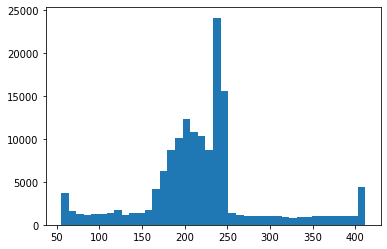

In [32]:
y_bif, df = y_bifurcation_position(trj)
x_bif = x_bifurcation_position(trj, y_bif)

In [33]:
x_bif

220.57933020154567

In [34]:
x_bif, y_bif, fit = improve_x_and_y_bif(trj,x_bif, y_bif)


1
2
3
6
8
10
12
26
27
35
38
39
41
43
45
46
47
48
49
50
51
52
53


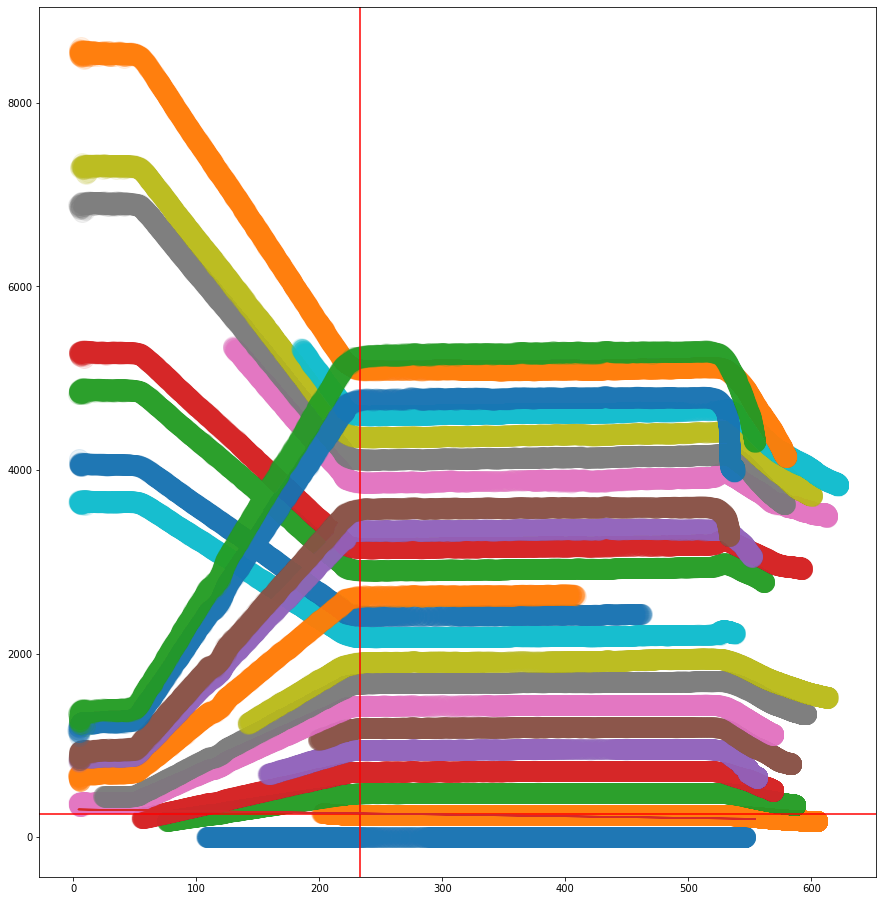

In [35]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in trj.groupby("particle"):
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [36]:
fit

[poly1d([-1.87285453e-01,  3.03902936e+02]),
 poly1d([-2.04919070e-01,  3.13113632e+02]),
 poly1d([-1.83627264e-01,  3.00702291e+02]),
 poly1d([-2.00037339e-01,  3.05288208e+02]),
 poly1d([-2.24511505e-01,  3.12180083e+02]),
 poly1d([-2.41968051e-01,  3.19739746e+02]),
 poly1d([-1.44195722e-01,  2.87659421e+02]),
 poly1d([-1.39684630e-01,  2.86977135e+02]),
 poly1d([-1.46887321e-01,  2.91626529e+02]),
 poly1d([1.97683476e-02, 2.36769627e+02]),
 poly1d([2.78656043e-03, 2.41302437e+02]),
 poly1d([1.61615812e-02, 2.34016544e+02]),
 poly1d([-7.55585552e-03,  2.45744627e+02]),
 poly1d([-4.61291961e-02,  2.59347686e+02]),
 poly1d([-2.54696962e-02,  2.46783320e+02]),
 poly1d([-2.29824625e-02,  2.45922930e+02]),
 poly1d([-7.51061891e-02,  2.70979195e+02]),
 poly1d([-6.23469895e-02,  2.64029695e+02]),
 poly1d([-9.82207934e-02,  2.76292722e+02]),
 poly1d([-1.17254632e-01,  2.83846639e+02]),
 poly1d([-1.17859904e-01,  2.78723061e+02]),
 poly1d([-1.22706719e-01,  2.85730710e+02]),
 poly1d([-9.6286

In [37]:
inter = up_or_down(trj,y_bif)

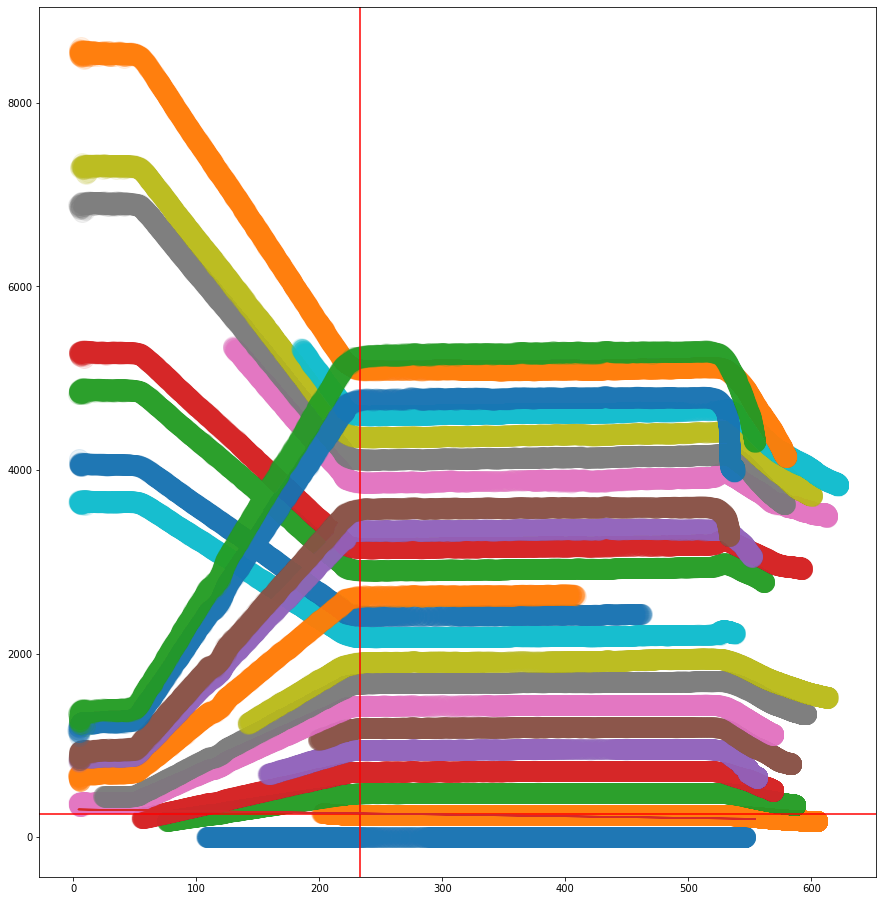

In [38]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in inter.groupby("particle"):
    
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [39]:
len(trj), len(inter)

(152243, 152243)

In [40]:
df_x = inter.query('x > '+str(x_bif))
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

In [41]:
len(df_x), len(df_d)

(95323, 95231)

1
2
3
6
8
10
12
26
27
35
38
39
41
43
45
46
47
48
49
50
51
52
53


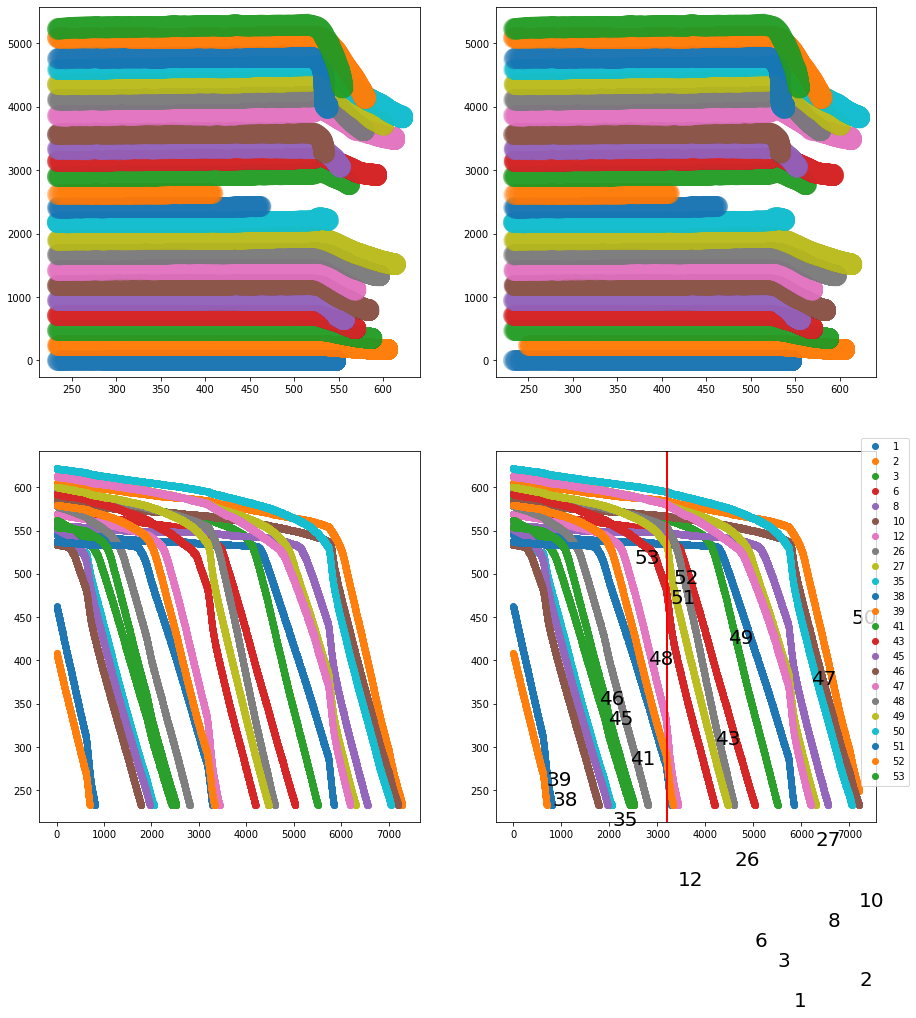

In [42]:
fig, (ax0,ax1) = plt.subplots(2,2, figsize = (15,15))

j = 0
for p,trj_p in df_x.groupby("particle"):
    
    ax0[0].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[0].plot(trj_p.frame, trj_p.x, 'o')
    j = j+1
    
j = 0
for p,trj_p in df_d.groupby("particle"):
    
    ax0[1].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[1].plot(trj_p.frame, trj_p.x, 'o', label = str(p))
    ax1[1].text(trj_p.frame.max(), trj_p.x.min()*0.1*j , s = str(p), size = 20)
    ax1[1].axvline(x=3200, color='r', linestyle='-')
    ax1[1].legend(bbox_to_anchor=(1.1, 1.05))


    print(str(p))

    

    j = j+1

In [44]:
df_d.query('frame == 3200')

,frame,particle,y,x,bif
78128,3200,6,190.926198,569.253359,DOWN
78129,3200,4,203.385591,546.803594,DOWN
78131,3200,1,195.143928,583.274082,DOWN
78139,3200,403,243.514358,366.789448,UP
78140,3200,56,242.812352,550.060485,UP
78141,3200,27,239.961572,386.000159,DOWN
78142,3200,52,240.498040,247.417581,DOWN
78143,3200,26,231.515748,538.104447,DOWN
78144,3200,51,222.176957,576.103349,UP
78145,3200,58,218.240265,559.996417,DOWN


In [43]:
%%time
df_last = []

df_x = inter.query('x > '+str(x_bif)+'& x < 500')
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

for frame in df_d['frame'].unique(): # Do analysis frame by frame
    
    pairs = create_pairs(df_d, frame)
    mag = magnetization(pairs, frame)
    df_last.append(d(mag, 1, 1)) # I need to introduce the pix/um conversion.

    
last = pd.concat(df_last)    

CPU times: user 1min 26s, sys: 1.44 s, total: 1min 27s
Wall time: 1min 25s


In [44]:
check_analysis(trj, last)

Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs


In [48]:
len(last.particle.unique())

23

In [ ]:
#last = last[last.p1 != 2] # To drop unuseful particles

In [45]:
last.groupby(['p1','p2']).size(), len(last.groupby(['p1','p2']).size()) 

(p1  p2
 1   27       8
     47    1786
 3   1     2022
 6   3     1470
 8   50    1508
 10  2     2150
 12  43     728
 26  6     1934
 27  8     1870
 35  41    2120
 38  46     614
 39  38    1396
 41  53    2410
 43  49    1824
 45  35    2524
 46  45    2230
 47  27    2266
 48  51    1716
 49  26    1884
 50  10    2334
 51  52    2196
 52  12    1836
 53  48    2024
 dtype: int64,
 23)

In [57]:
last1 = last[(last.p1 != 1)]
last1.groupby(['p1','p2']).size() 

p1  p2
3   1     2022
6   3     1470
8   50    1508
10  2     2150
12  43     728
26  6     1934
27  8     1870
35  41    2120
38  46     614
39  38    1396
41  53    2410
43  49    1824
45  35    2524
46  45    2230
47  27    2266
48  51    1716
49  26    1884
50  10    2334
51  52    2196
52  12    1836
53  48    2024
dtype: int64

In [60]:
last1 = last.query('p1 == 1 & p2 == 47')


In [61]:
last1.groupby(['p1','p2']).size() 

p1  p2
1   47    1786
dtype: int64

In [ ]:
last.groupby(['p1','p2']).size() 

In [ ]:
last1 = last[(last['p1'] == 1399) & (last['p2'] == 1680)]
last1.groupby(['p1','p2']).size() 

# Next step

Now I need to compute the main distance in the channel for pairs of particles and associate a magnetization value to this pair.

In [51]:
def distance_and_magnetization(df, x_bif):
    
    output = df.groupby(['p1','p2']).mean()
    output['d_err'] = df.groupby(['p1','p2']).distance.std()/np.sqrt(df.groupby(['p1','p2']).count()['distance'])
    
    return output

In [62]:
output = distance_and_magnetization(last1,x_bif)
output

,,frame,particle,y,x,magnetization,distance,d_err
p1,p2,,,,,,,
1,47,5395.712206,24.0,241.254038,385.455118,0.0,82.191661,0.059434


In [63]:
output.to_csv('magnetization_'+name+'_1.dat', sep = '\t')